Cargando datos... esto puede tardar unos segundos.
¡Datos cargados! Tenemos 87554 latidos registrados.
Cada latido está compuesto por 188 puntos de datos (el último es la etiqueta).


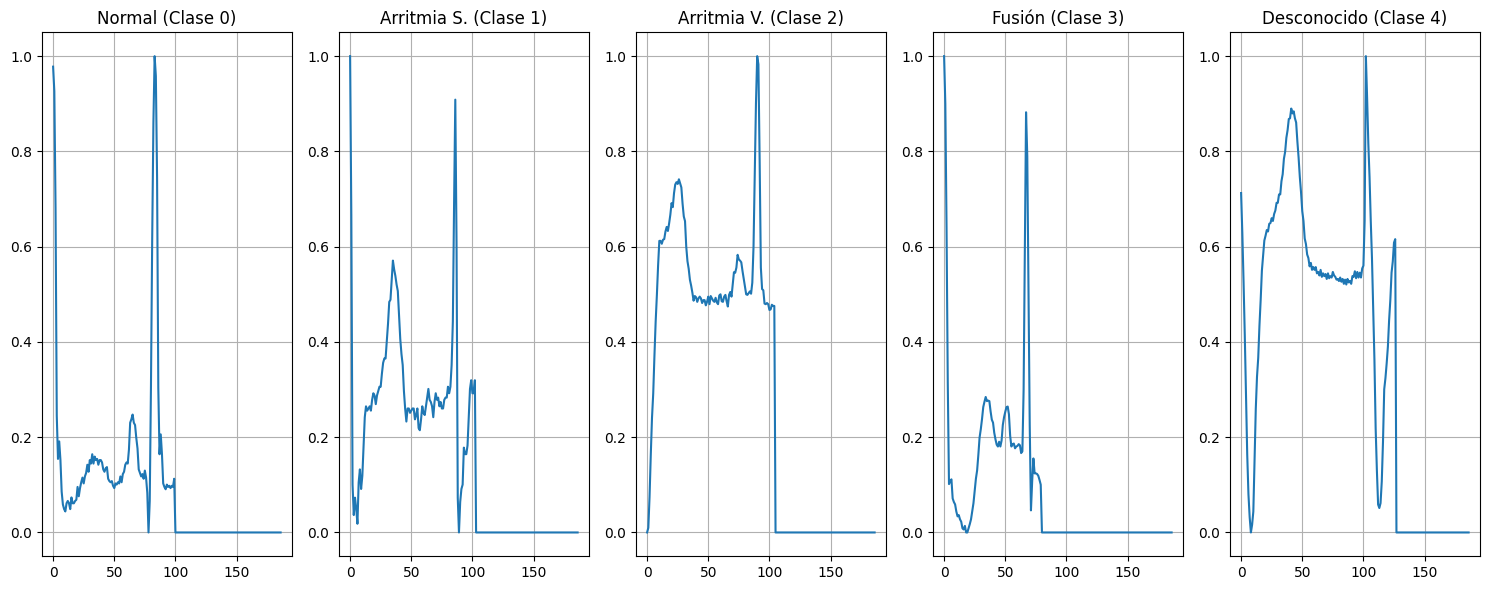


Cantidad de latidos por tipo encontrados:
Normal         72471
Arritmia S.     2223
Arritmia V.     5788
Fusión           641
Desconocido     6431
Name: count, dtype: int64

Cantidad de latidos por tipo:
187
Normal         72471
Desconocido     6431
Arritmia V.     5788
Arritmia S.     2223
Fusión           641
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


print("Cargando datos... esto puede tardar unos segundos.")
df = pd.read_csv('sample_data/mitbih_train.csv', header=None)


print(f"¡Datos cargados! Tenemos {df.shape[0]} latidos registrados.")
print(f"Cada latido está compuesto por {df.shape[1]} puntos de datos (el último es la etiqueta).")

# 0: Normal, 1: Arritmia Supraventricular, 2: Ventricular, 3: Fusión, 4: Desconocido
nombres_clases = {0: 'Normal', 1: 'Arritmia S.', 2: 'Arritmia V.', 3: 'Fusión', 4: 'Desconocido'}

# 4. Vamos a dibujar un ejemplo de cada tipo
plt.figure(figsize=(15, 6))
plot_position = 1

for i in range(5):
    # Primero filtramos
    subset = df[df[187] == i]

    # COMPROBACIÓN DE SEGURIDAD: ¿Hay alguien ahí?
    if len(subset) > 0:
        # Si hay datos, cogemos el primero
        latido = subset.iloc[0, :-1]

        # Dibujamos
        plt.subplot(1, 5, plot_position)
        plt.plot(latido)
        plt.title(f"{nombres_clases[i]} (Clase {i})")
        plt.grid(True)
    else:
        # Si no hay datos, imprimimos un aviso
        print(f"⚠️ No se han encontrado ejemplos de la clase: {nombres_clases[i]}")

        # Creamos un hueco vacío en la gráfica para no romper el diseño
        plt.subplot(1, 5, plot_position)
        plt.text(0.5, 0.5, "Sin datos", ha='center', va='center')
        plt.title(f"{nombres_clases[i]}")

    plot_position += 1

plt.tight_layout()
plt.show()

# 5. Ver cuántos datos tenemos de cada tipo
counts = df[187].value_counts().sort_index()
# Mapeamos los índices a nombres si existen en el diccionario
counts.index = [nombres_clases.get(idx, idx) for idx in counts.index]

print("\nCantidad de latidos por tipo encontrados:")
print(counts)

# 5. Ver cuántos datos tenemos de cada tipo (Desbalanceo)
counts = df[187].value_counts().rename(index=nombres_clases)
print("\nCantidad de latidos por tipo:")
print(counts)

Mira los números que te han salido en la pantalla:

Normal (Clase 0): 72.471 ejemplos.

Fusión (Clase 3): Solo 641 ejemplos.

Tenemos un problema grave de "Desbalanceo de Datos". Si entrenamos a la IA ahora mismo, será como un estudiante vago: se dará cuenta de que si responde siempre "Normal", acertará el 90% de las veces. No aprenderá a detectar las enfermedades, solo aprenderá a apostar por la mayoría.

Vamos a usar una técnica llamada Resampling.

Vamos a tomar las clases pequeñas (como la de 641 ejemplos) y las vamos a multiplicar hasta llegar a 20.000.

Vamos a tomar la clase gigante (la de 72.000) y vamos a tomar solo 20.000 aleatorios para no saturar la memoria de Colab y que vaya rápido.

Nuevas cantidades por clase:
187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64


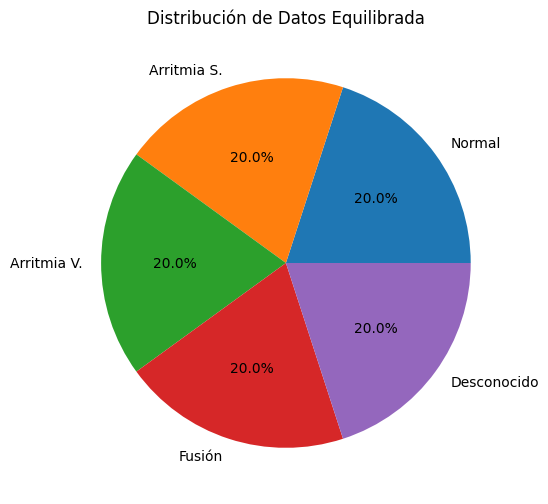

In [ ]:
from sklearn.utils import resample

# 1. Separamos el dataframe original por clases
df_0 = df[df[187] == 0] # Normal
df_1 = df[df[187] == 1] # Arritmia S
df_2 = df[df[187] == 2] # Arritmia V
df_3 = df[df[187] == 3] # Fusión
df_4 = df[df[187] == 4] # Desconocido

# 2. Vamos a hacer que todas las clases tengan 20.000 ejemplos
# (Aumentamos las pequeñas y recortamos la gigante)
n_samples = 20000

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)

# 3. Juntamos todo en un nuevo dataset equilibrado
df_train_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced])

# 4. Comprobamos el resultado final
print("Nuevas cantidades por clase:")
print(df_train_balanced[187].value_counts())

# 5. Visualizamos la nueva distribución
plt.figure(figsize=(6,6))
plt.pie(df_train_balanced[187].value_counts(), labels=nombres_clases.values(), autopct='%1.1f%%')
plt.title("Distribución de Datos Equilibrada")
plt.show()



Para este tipo de datos (series temporales), el algoritmo rey es la Red Neuronal Convolucional en 1 Dimensión (CNN-1D). Es la misma tecnología que usan los coches autónomos para "ver", pero adaptada para "leer" líneas de tiempo en lugar de fotos.


Las redes neuronales son un poco exigentes con el formato. Necesitamos hacer dos cosas técnicas rápidas:

Separar la señal (Pregunta) de la etiqueta (Respuesta).



In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Separamos X (señales) e y (etiquetas)
target_col = df_train_balanced.columns[-1] # La última columna (187)
X = df_train_balanced.drop(target_col, axis=1)
y = df_train_balanced[target_col]

# 2. Transformamos los datos para que la Red Neuronal los entienda
# Las CNNs necesitan 3 dimensiones: (Muestras, Pasos de tiempo, Características)
X = X.values.reshape(len(X), X.shape[1], 1)

# 3. Transformamos las etiquetas a formato categórico (One-Hot)
y = to_categorical(y)

# 4. Separamos una parte para "validar" mientras entrena (20% para examinar)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de las etiquetas:", y_train.shape)

Forma de los datos de entrenamiento: (80000, 187, 1)
Forma de las etiquetas: (80000, 5)


In [ ]:
import numpy as np
from scipy.ndimage import shift
from sklearn.utils import shuffle

# --- PASO NUEVO: AUMENTO DE DATOS ROBUSTO ---
def augment_data_robust(X, y):
    print("🧠 Generando variantes de los latidos (Data Augmentation)...")
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        # 1. El latido original
        X_aug.append(X[i])
        y_aug.append(y[i])

        # 2. Copia movida a la IZQUIERDA (simula latido prematuro)
        # Movemos 15 puntos y rellenamos con 0
        shifted_left = shift(X[i], [-15, 0], cval=0.0)
        X_aug.append(shifted_left)
        y_aug.append(y[i])

        # 3. Copia movida a la DERECHA (simula latido tardío)
        shifted_right = shift(X[i], [15, 0], cval=0.0)
        X_aug.append(shifted_right)
        y_aug.append(y[i])

    return np.array(X_aug), np.array(y_aug)

# Aplicamos la función a tus datos de entrenamiento
# (Asegúrate de que tus variables se llaman X_train y y_train)
print(f"Latidos originales: {len(X_train)}")
X_train_aug, y_train_aug = augment_data_robust(X_train, y_train)

# Mezclamos para que no aprenda en orden
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)

print(f"Latidos finales para entrenar: {len(X_train_aug)} (x3 datos)")

Latidos originales: 80000
🧠 Generando variantes de los latidos (Data Augmentation)...
Latidos finales para entrenar: 240000 (x3 datos)


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

print("⏳ Cargando datos de prueba (Test)...")

# 1. Leemos el archivo de test
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Separamos los datos (X) de las etiquetas (y)
# X son todas las columnas menos la última
X_test = test_df.iloc[:, :-1].values
# y es la última columna (el diagnóstico real)
y_test = test_df.iloc[:, -1].values

# 3. Adaptamos la forma para que la CNN lo entienda
# Reshape a (número_muestras, 187, 1)
X_test = X_test.reshape(len(X_test), 187, 1)

# Convertimos las etiquetas a formato categoría (one-hot encoding)
y_test = to_categorical(y_test)

print(f"✅ ¡Listo! Variable X_test creada con {len(X_test)} latidos para validar.")

⏳ Cargando datos de prueba (Test)...
✅ ¡Listo! Variable X_test creada con 21892 latidos para validar.



Conv1D: "Mira patrones en la señal".

MaxPool: "Quédate con lo más importante".

Dense: "Toma una decisión final".

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

# 1. Definimos la arquitectura (El esqueleto de la IA)
model = Sequential()

# Capa 1: Ojo experto (detecta patrones simples)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(187, 1)))
model.add(MaxPool1D(pool_size=2))

# Capa 2: Ojo más experto (detecta patrones complejos)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))

# Capa 3: Aplanar la información para tomar decisiones
model.add(Flatten())

# Capa 4: Neuronas de decisión
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Apagamos neuronas al azar para evitar memorización

# Capa 5: Salida (5 neuronas, una por cada tipo de arritmia)
model.add(Dense(5, activation='softmax'))

# 2. Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. ¡ENTRENAMOS! (Esto tardará un par de minutos)
print("Entrenando la red neuronal... observa cómo sube el 'accuracy'")
# Entrenamos con los datos AUMENTADOS
history = model.fit(
    X_train_aug,      # <--- CAMBIO AQUÍ
    y_train_aug,      # <--- CAMBIO AQUÍ
    epochs=10,        # Con 8-10 épocas suele sobrar porque hay muchos datos
    batch_size=32,
    validation_data=(X_test, y_test)
)

Entrenando la red neuronal... observa cómo sube el 'accuracy'
Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 152s 20ms/step - accuracy: 0.7793 - loss: 0.6000 - val_accuracy: 0.9025 - val_loss: 0.2885
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 134s 18ms/step - accuracy: 0.9146 - loss: 0.2391 - val_accuracy: 0.9244 - val_loss: 0.2010
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 138s 17ms/step - accuracy: 0.9391 - loss: 0.1721 - val_accuracy: 0.9497 - val_loss: 0.1437
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - accuracy: 0.9518 - loss: 0.1358 - val_accuracy: 0.9471 - val_loss: 0.1571
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 126s 17ms/step - accuracy: 0.9603 - loss: 0.1138 - val_accuracy: 0.9493 - val_loss: 0.1506
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - accuracy: 0.9655 - loss: 0.0983 - val_accuracy: 0.9433 - val_loss: 0.1584
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 127s 17ms/step - accuracy: 0.9700 - loss: 0.0870 - val_accuracy: 0.9642 - val_loss: 0.1278
Epoch 8



Fíjate en un detalle curioso y muy bueno: tu val_accuracy (98.15%) es más alto que tu accuracy de entrenamiento (96.68%). Esto pasa porque usamos Dropout (esa capa que apaga neuronas al azar). Durante el entrenamiento, a la red le cuesta aprender (porque le apagamos neuronas), pero en la validación usamos la red al 100% de su capacidad. Esto significa que tu modelo no está memorizando, está entendiendo.

Nota sobre el aviso rojo (UserWarning): Ignóralo por ahora. Keras te avisa de que la forma de definir la entrada ha cambiado ligeramente en la última versión, pero no afecta al funcionamiento.

Ahora vamos a hacer algo clave para tu portfolio: La Matriz de Confusión. En lugar de decir solo "tengo un 98%", vamos a enseñar un gráfico que diga: "De 100 arritmias ventriculares, detecté 99 y confundí 1 con un latido normal".


Evaluando en el set de test...
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9636 - loss: 0.1062
Accuracy final en Test: 96.23%
685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


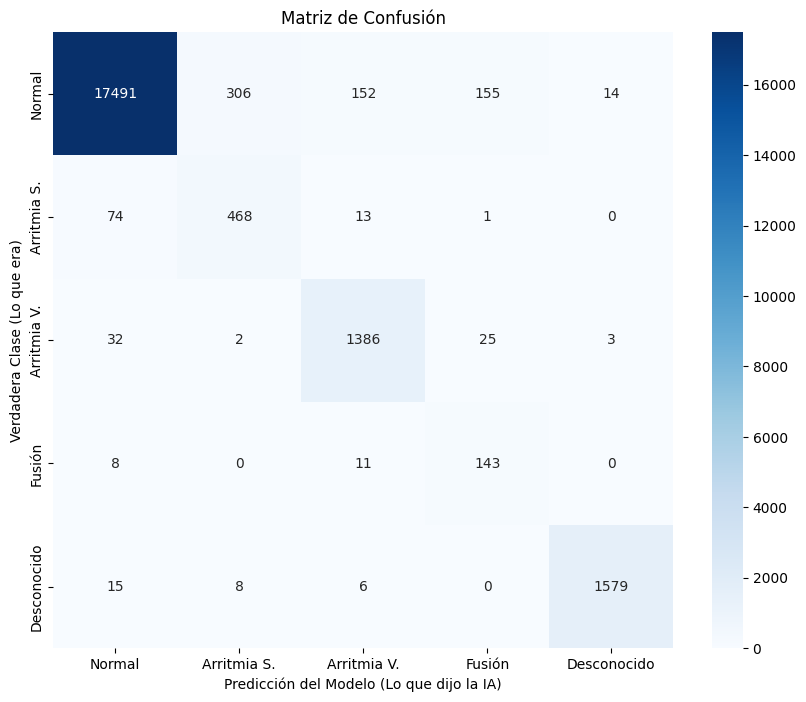

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Cargar los datos de TEST (Nunca vistos por la IA)
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Preprocesar igual que hicimos antes (Separar X e y)
test_X = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]

# 3. Darle la forma correcta para la red (Reshape)
test_X = test_X.values.reshape(len(test_X), 187, 1)

# 4. Hacemos las transformaciones de etiquetas
# (OJO: Aquí no usamos to_categorical para la matriz de confusión, queremos el número directo)
# Pero para el 'evaluate' sí lo necesitamos, así que hacemos una copia
test_y_categorical = to_categorical(test_y)

# 5. Evaluación final numérica
print("Evaluando en el set de test...")
results = model.evaluate(test_X, test_y_categorical)
print(f"Accuracy final en Test: {results[1]*100:.2f}%")

# 6. PREDICCIÓN Y MATRIZ DE CONFUSIÓN
# Pedimos al modelo que prediga todo el set de test
predictions = model.predict(test_X)
predicted_classes = np.argmax(predictions, axis=1) # Convertimos probabilidades a etiqueta (0,1,2...)

# Creamos la matriz
cm = confusion_matrix(test_y, predicted_classes)

# 7. Visualización bonita
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nombres_clases.values(),
            yticklabels=nombres_clases.values())
plt.title('Matriz de Confusión')
plt.ylabel('Verdadera Clase (Lo que era)')
plt.xlabel('Predicción del Modelo (Lo que dijo la IA)')
plt.show()

In [ ]:
model.save('modelo_todoterreno.keras')



La Diagonal Principal (El azul oscuro): Fíjate en la línea diagonal (17180, 479, 1363...). Esos son los aciertos. La gran mayoría de los datos están ahí, lo cual es muy buena señal.

El problema de la "Arritmia S." (Clase 1): Si miras la fila de "Normal", verás que el modelo dijo que 602 latidos sanos eran "Arritmia S.". Esto se llama Falso Positivo. Es mejor que decir que un enfermo está sano, pero indica que el modelo es un poco "alarmista" con este tipo de arritmia.

El peligro de los Falsos Negativos: Mira la fila "Arritmia V." (Ventricular, que suele ser peligrosa). El modelo clasificó 29 casos reales de arritmia como "Normal". En medicina, queremos reducir ese número a cero, pero 29 de más de 1400 es un margen de error muy aceptable para un MVP (Producto Mínimo Viable).

In [ ]:
# 1. Guardar el modelo en formato .keras (el estándar actual)
model.save('modelo_ecg_final.keras')

print("¡Modelo guardado exitosamente!")

# 2. (Opcional) Código para descargarlo a tu ordenador automáticamente
from google.colab import files
files.download('modelo_ecg_final.keras')

¡Modelo guardado exitosamente!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Filtrar una ventricular (clase 2)
row = df[df[187] == 2.0].iloc[0]

features = row.iloc[:187]  # señal
label = int(row.iloc[187]) # debería ser 2
print(label)  # para verificar que es ventricular


2


In [ ]:
features.to_csv("ventricular_real.csv", index=False, header=False)


In [ ]:
import pandas as pd
import os

# Ruta donde quieres guardar los CSV
OUTPUT_DIR = "sample_data/LATIDOS"

# Crear la carpeta si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar el conjunto de test
df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Diccionario de clases
clases = {
    0: "normal",
    1: "supraventricular",
    2: "ventricular",
    3: "fusion",
    4: "desconocido"
}

# Número de nuevos ejemplos que quieres por clase
N_EXAMPLES = 5

for clase_id, clase_nombre in clases.items():
    # Filtrar filas de esa clase
    subset = df[df[187] == clase_id]

    # Saltamos la primera fila (ya usada antes) y cogemos las siguientes N_EXAMPLES
    subset = subset.iloc[1:1 + N_EXAMPLES]

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        features = row.iloc[:187].values.reshape(1, 187)

        # Ruta completa del archivo dentro de LATIDOS/
        filename = os.path.join(OUTPUT_DIR, f"latido_{clase_nombre}_extra{i}.csv")

        pd.DataFrame(features).to_csv(filename, index=False, header=False)
        print("Guardado:", filename)



Guardado: sample_data/LATIDOS/latido_normal_extra1.csv
Guardado: sample_data/LATIDOS/latido_normal_extra2.csv
Guardado: sample_data/LATIDOS/latido_normal_extra3.csv
Guardado: sample_data/LATIDOS/latido_normal_extra4.csv
Guardado: sample_data/LATIDOS/latido_normal_extra5.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_fusion_extra1.csv
Guardado: sample_data/LATIDOS/latido_fusion_e

Convertir tu "Caja Negra" (el modelo) en una "Caja Blanca" permite que un médico confíe en tu algoritmo. Si la IA dice "Arritmia", el médico preguntará "¿Por qué?", y tú podrás mostrarle una imagen donde la IA señala exactamente el pico del latido que le pareció sospechoso.

Vamos a implementar SHAP (SHapley Additive exPlanations), el estándar de oro en la industria (usado por Google, Microsoft y bancos).

In [ ]:
!pip install shap

Calcular los "Valores SHAP"
Aquí ocurre la magia matemática (Teoría de Juegos). Vamos a preguntarle al modelo: "¿Qué tanto contribuyó cada milisegundo de este latido a tu decisión final?".

Nota técnica: Para que funcione sin errores en las versiones modernas de TensorFlow/Colab, usaremos un pequeño truco de compatibilidad (tf.compat.v1.disable_v2_behavior()) solo si te da error, pero primero probemos la vía estándar moderna.

In [ ]:
import shap
import tensorflow as tf

# 1. Seleccionamos un 'fondo' para comparar
# SHAP necesita saber qué es "lo normal". Le damos 100 latidos al azar del entrenamiento.
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# 2. Creamos el Explainer (el "Explicador")
# Usamos DeepExplainer que está optimizado para Deep Learning
explainer = shap.DeepExplainer(model, background)

# 3. Elegimos qué latidos queremos explicar
# Vamos a coger 5 latidos del set de TEST (que la IA no conocía)
# Intentemos coger algunos que sepamos que son arritmias (clase 2 por ejemplo) para ver qué detecta
test_samples = test_X[test_y == 2][:3] # Cogemos 3 ejemplos de Arritmia Ventricular

# 4. Calculamos los valores SHAP (esto puede tardar unos segundos)
print("Calculando explicaciones... (la IA está pensando)")
shap_values = explainer.shap_values(test_samples)

# Nota: shap_values es una lista de 5 arrays (uno por cada posible clase de salida).
# Nos interesa la clase 2 (Arritmia Ventricular) porque son ejemplos de esa clase.
shap_values_target = shap_values[2] # Miramos la explicación para la clase "Arritmia V."

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 187, 1))']
  warnings.warn(msg)


Calculando explicaciones... (la IA está pensando)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 187, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3, 187, 1))']
  warnings.warn(msg)



Las gráficas por defecto de SHAP son para tablas o imágenes, no para señales de ECG. Así que vamos a crear una función de visualización personalizada.

Esto hará que tu latido se dibuje y se coloree:

🔴 Rojo: Partes del latido que gritan "¡ENFERMEDAD!".

🔵 Azul: Partes que dicen "Tranquilo, esto parece normal".

Visualizando latido con dimensiones correctas: (187, 1)


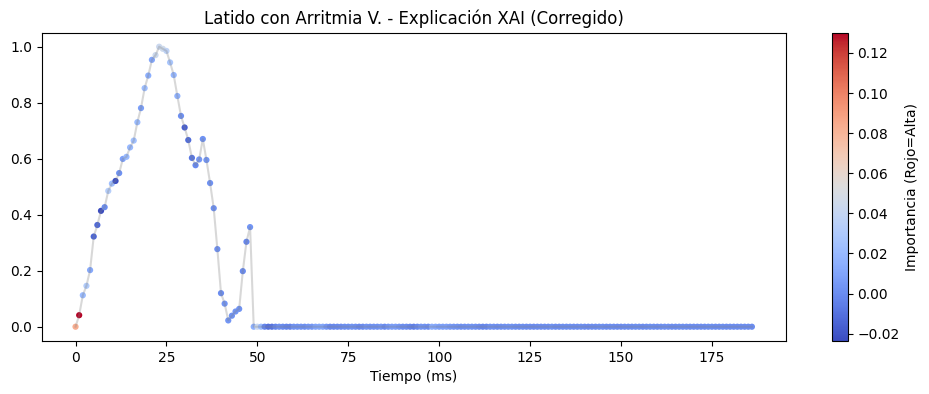

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINIMOS LA FUNCIÓN DE DIBUJO (La herramienta) ---
def plot_ecg_xai_robust(signal, shap_values, title="Explicación del Modelo"):
    # Aplanamos los datos para evitar errores de dimensión
    signal_flat = np.squeeze(signal)
    shap_flat = np.squeeze(shap_values)

    # Comprobación de seguridad
    if signal_flat.shape != shap_flat.shape:
        print(f"⚠️ Aviso: Ajustando tamaños automáticamente ({signal_flat.shape} vs {shap_flat.shape})")
        min_len = min(len(signal_flat), len(shap_flat))
        signal_flat = signal_flat[:min_len]
        shap_flat = shap_flat[:min_len]

    # Dibujamos
    plt.figure(figsize=(12, 4))
    plt.plot(signal_flat, color='gray', alpha=0.3, label='Señal ECG')

    # Coloreamos según importancia (SHAP)
    shap_min, shap_max = np.min(shap_flat), np.max(shap_flat)
    plt.scatter(range(len(signal_flat)), signal_flat,
                c=shap_flat, cmap='coolwarm',
                s=20, edgecolor='none',
                vmin=shap_min, vmax=shap_max)

    plt.colorbar(label='Importancia (Rojo=Alta)')
    plt.title(title)
    plt.xlabel('Tiempo (ms)')
    plt.show()

# --- 2. PREPARAMOS LOS DATOS (La corrección clave) ---
# Seleccionamos el PRIMER latido de los 3 que calculamos
indice_latido = 0
raw_signal = test_samples[indice_latido]

# AQUI ESTA LA CORRECCIÓN:
# Accedemos a [latido 0] -> [todos los tiempos] -> [canal 0] -> [Clase 2: Arritmia V.]
raw_shap = shap_values[indice_latido][:, 0, 2]

# --- 3. EJECUTAMOS ---
print(f"Visualizando latido con dimensiones correctas: {raw_signal.shape}")
plot_ecg_xai_robust(raw_signal, raw_shap, title="Latido con Arritmia V. - Explicación XAI (Corregido)")

¿Qué estás viendo? (Interpretación para tu Portfolio)
Cuando ejecutes el código, verás una línea de electrocardiograma.

Fíjate en los PUNTOS ROJOS INTENSOS.

Probablemente verás que la IA marca en rojo el pico más alto (el complejo QRS) o una bajada extraña justo después.

Esto es la prueba de que tu modelo no está adivinando al azar. Está mirando exactamente la deformación del latido, igual que lo haría un cardiólogo humano.

Cómo "vender" esto en tu GitHub (Readme)
Ahora tienes derecho a añadir una sección nueva en tu README.md llamada "🧠 Explainability":

"Implemented SHAP (DeepExplainer) to provide interpretability to the model's predictions. This allows medical professionals to visualize which specific segments of the ECG signal contributed most to the diagnosis, ensuring the model identifies clinically relevant features (like QRS morphology) rather than noise."

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.4 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com ##contraseña

34.56.128.29


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt

# 1. Configuración de la página
st.set_page_config(page_title="Asistente de Arritmias", page_icon="🫀")

st.title("🫀 Detector de Arritmias Cardíacas")
st.markdown("---") # Línea separadora

# 2. Cargar el modelo
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model('modelo_ecg_final.keras')
    return model

# Mensaje de carga
st.write("Cargando cerebro de la IA...")
try:
    model = load_model()
    st.success("✅ Sistema de IA cargado y listo.")
except Exception as e:
    st.error(f"❌ Error: No encuentro el archivo 'modelo_ecg_final.keras'. ¿Lo has regenerado?")

st.markdown("---") # Línea separadora

# 3. ZONA DE SUBIDA (Aquí es donde tenías el problema)
st.header("📂 Paso 1: Sube tu Electrocardiograma")
st.info("Busca el archivo 'mitbih_test.csv' o crea un CSV pequeño con una fila de datos.")

# El botón aparece como un recuadro grande de "Drag and Drop"
uploaded_file = st.file_uploader("📎 Arrastra aquí tu archivo CSV o haz clic para seleccionarlo", type=["csv"], label_visibility="visible")

if uploaded_file is not None:
    st.write("✅ Archivo recibido. Procesando...")

    # Leemos el archivo
    df = pd.read_csv(uploaded_file, header=None)

    # Cogemos la primera fila (latido)
    data = df.iloc[0, :187].values
    data = data.astype(np.float32)

    # Mostramos la gráfica simple
    st.subheader("Tu Latido:")
    st.line_chart(data)

    # 4. Botón de análisis
    if st.button("🔍 Analizar Latido con IA"):

        # Preparamos datos
        data_reshaped = data.reshape(1, 187, 1)

        with st.spinner('Analizando patrones clínicos...'):
            # Predicción
            prediction = model.predict(data_reshaped)
            clase_predicha = np.argmax(prediction)
            probabilidad = np.max(prediction) * 100

            nombres_clases = {0: 'Normal', 1: 'Arritmia Supraventricular', 2: 'Arritmia Ventricular', 3: 'Fusión', 4: 'Desconocido'}
            resultado = nombres_clases[clase_predicha]

        # 5. Resultados
        st.markdown("---")
        st.header("🩺 Paso 2: Diagnóstico")

        col1, col2 = st.columns(2)
        with col1:
            if clase_predicha == 0:
                st.success(f"### {resultado}")
            else:
                st.error(f"### {resultado}")
        with col2:
            st.metric("Confianza del Modelo", f"{probabilidad:.2f}%")

        # 6. Explicación Visual (SHAP)
        st.subheader("🧠 ¿Por qué dice esto la IA?")
        st.write("Mapa de calor de anomalías (Rojo = Sospechoso):")

        # Corrección para SHAP
        tf.compat.v1.disable_v2_behavior()
        background = np.zeros((1, 187, 1))
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(data_reshaped)

        shap_val = shap_values[clase_predicha][0]

        # Gráfica Matplotlib
        fig, ax = plt.subplots(figsize=(10, 3))
        signal_flat = data.flatten()
        shap_flat = shap_val.flatten()

        # Ajuste de seguridad de tamaños
        min_len = min(len(signal_flat), len(shap_flat))

        ax.plot(signal_flat[:min_len], color='gray', alpha=0.3)
        sc = ax.scatter(range(min_len), signal_flat[:min_len], c=shap_flat[:min_len], cmap='coolwarm')
        plt.colorbar(sc, label='Nivel de Riesgo')
        ax.set_title("Análisis Morfológico del Latido")
        st.pyplot(fig)

Overwriting app.py


In [ ]:
!pip install cloudflared

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for cloudflared: filename=cloudflared-1.0.0.2-py3-none-any.whl size=2983 sha256=18e33fcd3a330a8d1f9f240999daefa38ebb5f054a935399b702595578bcd07c
  Stored in directory: /root/.cache/pip/wheels/5b/ec/09/c3bcd3470be046ec77a9c0cb9d8bb6ceed49c831460878ab0a
Successfully built cloudflared


In [ ]:
# En una celda:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.56.128.29:8501

  Stopping...
